# 📑Discord `question-center` April recap (draft)

## I. Import library and connect database

In [218]:
import pandas as pd
from ast import literal_eval
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "simple_white"

import sqlite3
conn = sqlite3.connect('teo.db')

In [219]:
df = pd.read_csv("data/threads.csv", 
                 parse_dates=['created_at'], 
                 converters={'tags': literal_eval,'messages': literal_eval})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          117 non-null    int64         
 1   name        117 non-null    object        
 2   created_at  117 non-null    datetime64[ns]
 3   author_id   117 non-null    int64         
 4   tags        117 non-null    object        
 5   messages    117 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.6+ KB


## II. Thread interactions

### Most active learners

In [220]:
print(f"Number of learners posted questions: {df['author_id'].nunique()}")

Number of learners posted questions: 43


In [221]:
# Get all users from database
df_user = pd.read_sql_query("select * from users", conn)
# Count threads by user
df_thread_counts = df['author_id'].value_counts().rename_axis('id').reset_index(name='number_of_threads')

In [222]:
df_merged = pd.merge(df_thread_counts, df_user, how="left", on='id')
df_merged[['name', 'number_of_threads']].head()

,name,number_of_threads
0,Quí Trần,21
1,Đặng Thanh Tùng,16
2,Nhật Huy,10
3,Thanh Hiền,9
4,Tien Hoang,6


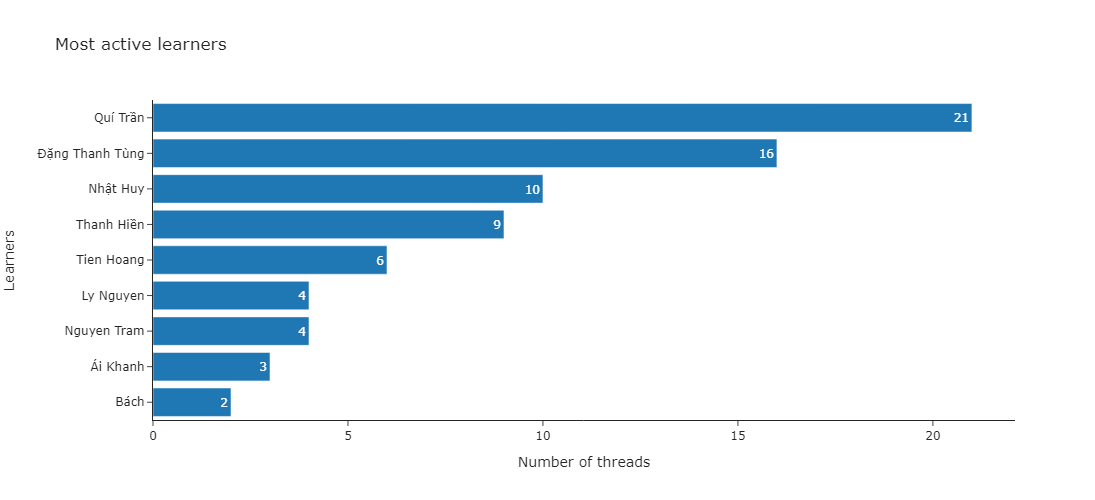

In [223]:
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(
    x=df_merged['number_of_threads'].head(10)[::-1],
    y=df_merged['name'].head(10)[::-1],
    orientation='h',
    text=df_merged['number_of_threads'].head(10)[::-1],
    hovertemplate='%{x} threads<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Most active learners',
    xaxis=dict(title='Number of threads'),
    yaxis=dict(title='Learners'),
    height=500,
    hoverlabel=dict(bgcolor='#000', font_color='#fff')
)
# Show plot
fig.show()

**NOTE**: cannot calculate percentage since every Discord member has the #learner tag as default 

### Busiest hour/day

In [224]:
# Extract day of week and hour
df['Day'] = df['created_at'].dt.day_name()
df['Hour'] = df['created_at'].dt.hour

# Count threads by day and hour
df_busy_day = df.groupby(['Day']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'number_of_threads'})
df_busy_hour = df.groupby(['Hour']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'number_of_threads'})

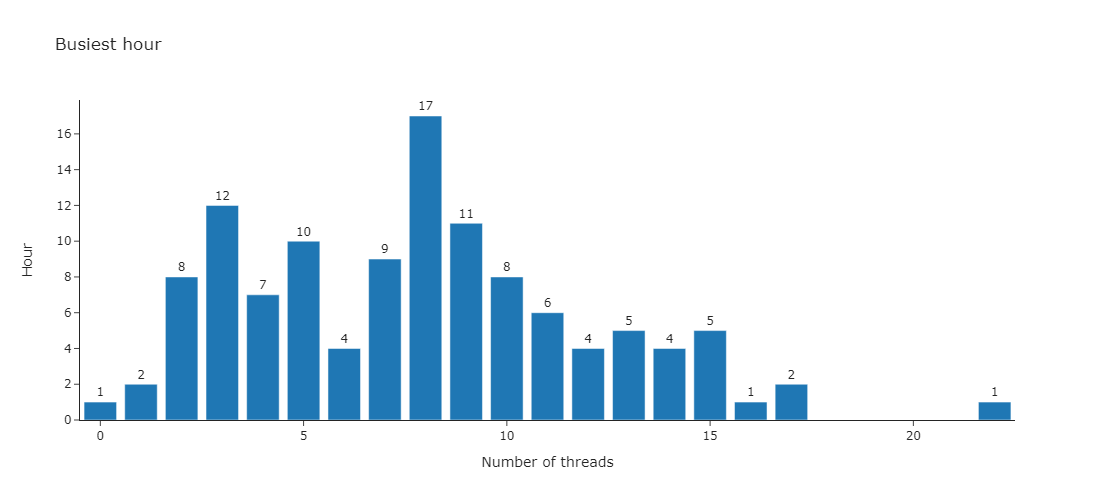

In [225]:
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(
    x=df_busy_hour['Hour'],
    y=df_busy_hour['number_of_threads'],
    text=df_busy_hour['number_of_threads'],
    textposition='outside',
    hovertemplate='%{y}h: %{x} threads<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Busiest hour',
    xaxis=dict(title='Number of threads'),
    yaxis=dict(title='Hour'),
    height=500,
    hoverlabel=dict(bgcolor='#000', font_color='#fff')
)
# Show plot
fig.show()

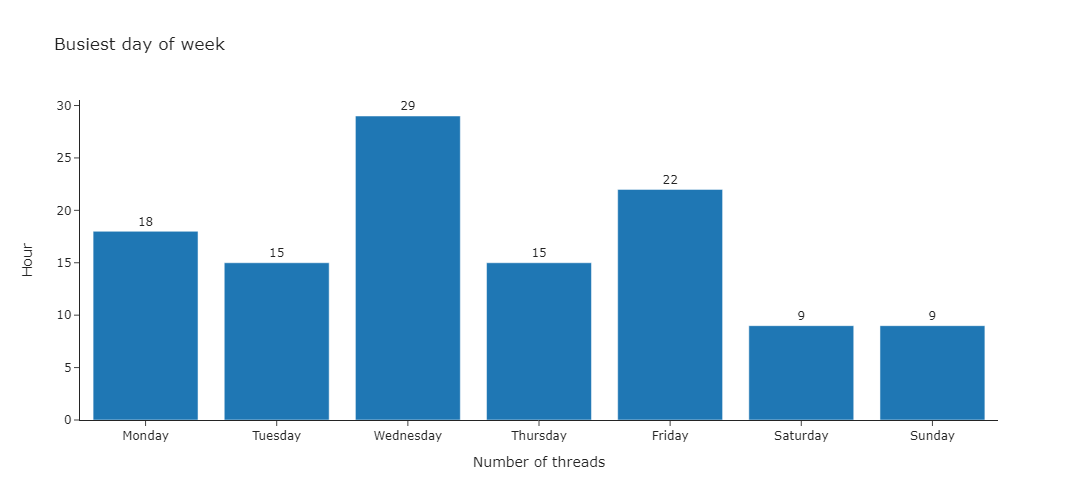

In [235]:
# Convert the 'Day' column to a categorical type with the specified order
df_busy_day['Day'] = pd.Categorical(df_busy_day['Day'], 
                                    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                    ordered=True)

# Sort the DataFrame by the 'Day' column
df_busy_day = df_busy_day.sort_values(by='Day')

fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(
    x=df_busy_day['Day'],
    y=df_busy_day['number_of_threads'],
    text=df_busy_day['number_of_threads'],
    textposition='outside',
    hovertemplate='%{y}: %{x} threads<extra></extra>'
))

# Update layout
fig.update_layout(
    title='Busiest day of week',
    xaxis=dict(title='Number of threads'),
    yaxis=dict(title='Hour'),
    height=500,
    width=700,
    hoverlabel=dict(bgcolor='#000', font_color='#fff')
)
# Show plot
fig.show()

**NOTE**:
- `Busiest days`: Wednesday and Friday
- `Busiest period`: 12AM to 5PM

## III. Courses material and Staff

### Most asked modules

In [227]:
df_tag = pd.read_sql_query("select * from tags", conn)

In [228]:
df_tag_counts = df.explode('tags')['tags'].value_counts().rename_axis('id').reset_index(name='number_of_threads')

In [229]:
# Dictionary for module names
module_names = {
    'M1.1': 'SQL Basics',
    'M1.2': 'SQL Advanced',
    'M2.1': 'Python 101',
    'M3.1': 'Pandas basics',
    'M3.2': 'Prepare your data',
    'M4': 'Data visualization'}

In [230]:
df_merged = pd.merge(df_tag_counts, df_tag, how="left", on='id')
df_merged = df_merged.dropna(subset=['name']).reset_index(drop=True)

In [231]:
df_merged['module'] =  df_merged['name'].apply(lambda x: module_names.get(x, x))
df_merged[['module', 'number_of_threads']]

,module,number_of_threads
0,SQL Advanced,24
1,SQL Basics,21
2,Prepare your data,14
3,Data visualization,12
4,Python 101,10
5,Pandas basics,10
6,Final,7
7,Machine learning,2
8,Data visualization,1


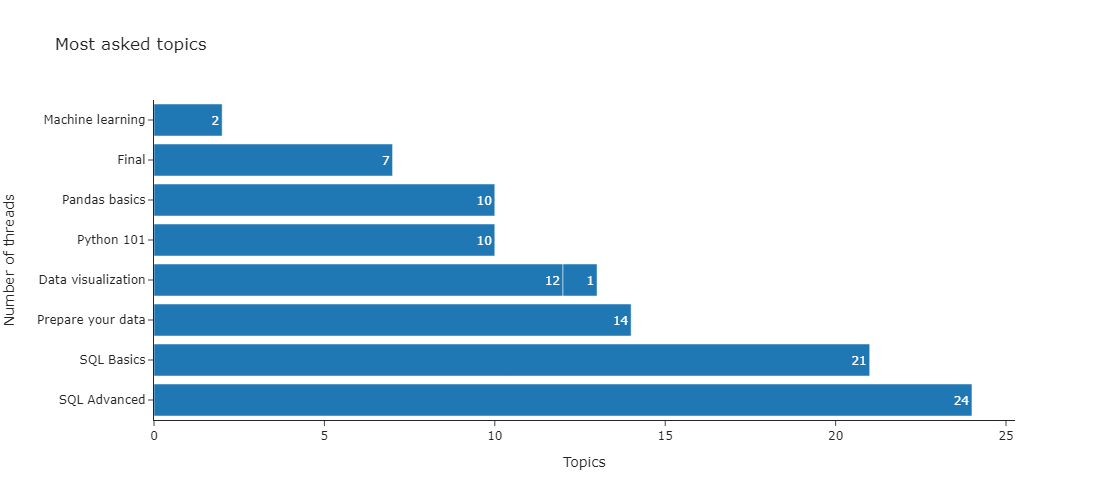

In [236]:
fig = go.Figure()

# Add bar trace
fig.add_trace(go.Bar(
    x=df_merged['number_of_threads'],
    y=df_merged['module'],
    text=df_merged['number_of_threads'],
    customdata=df_merged['name'],
    hovertemplate='Tag: #%{customdata}<extra></extra>',
    orientation='h'
))

fig.update_layout(
    title='Most asked topics',
    xaxis=dict(title='Topics'),
    yaxis=dict(title='Number of threads'),
    height=500,
    hoverlabel=dict(bgcolor='#000', font_color='#fff')
)
fig.show()

### Response time

In [233]:
df['response'] = pd.to_datetime(df['messages'].apply(lambda x: x[-2]['created_at']))
df['response_time'] = df['response'] - df['created_at']
df['response_time']

0     0 days 00:08:08
1     0 days 00:21:52
2     0 days 00:28:34
3     0 days 00:15:55
4     0 days 08:51:20
            ...      
112   0 days 00:23:09
113   0 days 00:05:32
114   0 days 00:03:13
115   0 days 00:03:52
116   0 days 00:06:16
Name: response_time, Length: 117, dtype: timedelta64[ns]

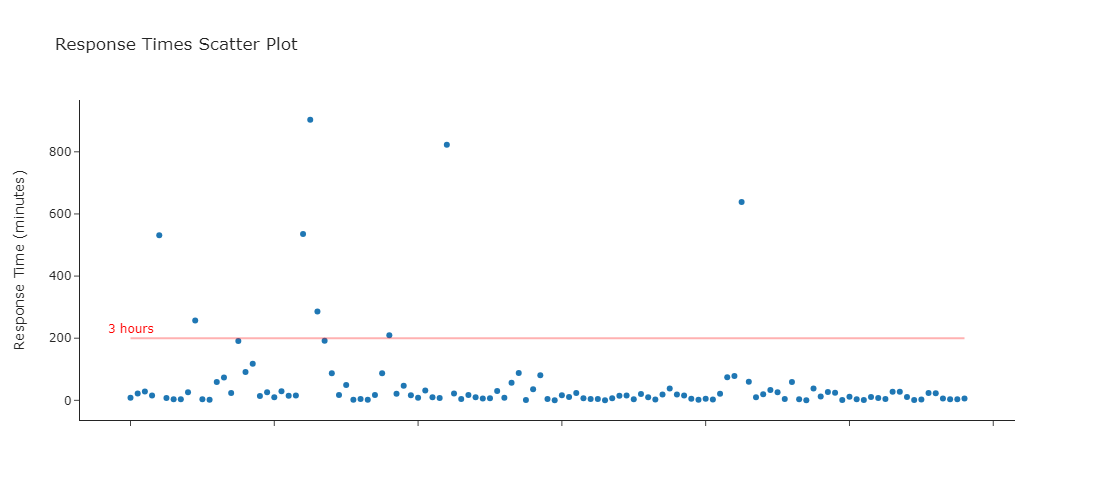

In [234]:
fig = go.Figure(data=go.Scatter(x=df.index, 
                                y=df['response_time'].dt.total_seconds() / 60, 
                                mode='markers',
                                text=df['created_at'].dt.date,
                                hovertemplate='Posted on %{text}<extra></extra>'
                               ))
fig.update_layout(
    title='Response Times Scatter Plot',
    yaxis_title='Response Time (minutes)',
    height=500
)
fig.update_xaxes(title=None, showticklabels=False)

fig.add_shape(type="line",
              x0=df.index.min(), y0=200, 
              x1=df.index.max(), y1=200,
              line=dict(color="red", width=2))
fig.add_annotation(x=df.index.min(), y=230,
                   text="3 hours",
                   showarrow=False,
                   font_color="red")
fig.show()

**NOTE**: Response time is determined by subtracting the initial reply message from the time the thread was created

    response_time = time_of_first_reply - created_time_of_thread

For threads that have delayed response:
- Some threads were posted after 10pm -> responded the next day
- After posting thread on forum, learner contact TA directly for solution. Solved in group chat.
- TA sessions are full on Wednesday and Friday morning shift -> some threads were responded late on those days (longest: 4 hours 18/4) 

## Bonus: Pipeline overview

![](pipeline.png)